# Fake news recognition using a Multinomial Naive Bayes Classifier

## First part: Kumar Dataset

### Course: Advanced Statistics for Physics Analysis
### Students: Feltrin Antonio (2097126), Toso Simone (2095484)

In [3]:
library(tidyverse)
library(stringr)
library(tm)            #Text-mining package
library(NLP) 
library(textstem)      #For lemmatization

# A bit of theory

Our aim is to *classify* some phrases, using a predetermined set of categories $\mathcal{C}$ (e.g. `{reliable, unreliable}`).

To do so, we must learn a *classification function* $\gamma: \mathcal{X} \to \mathcal{C}$, where $\mathcal{X}$ is the set of all possible input phrases. 

There are many possible algorithms for text classification in natural language processing. In this project we will focus on the *Multinomial Naive Bayes* classifier.

### The MNB classifier
Given a class $c$ and a *document* (i.e. phrase) $d$, we can imagine that the document was composed by randomly extracting words from the total set of tokens $\mathcal{T} = \{t_1, t_2, \dots, t_m\}$. This way, the probability of composing the observed document would be

$P(d|c) = \prod_{1 \leq k \leq n_d} p(t_k|c)$.

Now, we want to infer $P(c|d)$. This can be done through Bayes's Theorem:

$P(c|d) \propto p(c) \prod_{1 \leq k \leq n_d} p(t_k|c)$.

We can then easily find the *maximum a posteriori* class $c_{map}$:

$c_{map} = \mathrm{argmax}_{c} P(d|c)$.

The maximum a posteriori class will be our guess for the classification.





### The learning algorithm
Our model depends on the following parameters:
* **Prior**: $p(c)$. 
* **Token probability**: $p(t_k|c)$, the probability for token $t_k$ to appear in a document of class $c$, including multiple occurences in the same document. 

The prior can be estimated as $\hat{p}(c) = \frac{N_c}{N}$, i.e. the fraction of documents of class $c$ in the training set.

The token probability can instead be estimated as $\hat{p}(t|c) = \frac{T_{ct} + 1}{\sum_{t'} (T_{ct' + 1})}$. The term $T_{ct}$ is the number of times token $t$ appears in a document of class $c$. Notice that, both at the numerator and denominator, we are adding $1$ to $T_{ct}$ and $T_{ct'}$. This is done in order to avoid having $p(t|c) = 0$ for tokens that never appear in documents of class $c$.



___

# Kumar dataset 

We first try our hand on [this](https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv) dataset. It consists of 11507 records (10240 for training, 1267 for testing). The records are obtained from social media or news platforms.

Each entry is classified as one of these 6 categories:
* *Barely true* - 0
* *False* - 1
* *Half-true* - 2
* *Mostly true* - 3
* *Not known* - 4
* *True* - 5

## Read the data

In [4]:
dir_input <- 'data/kumar/train_pruned.csv'
dir_test <- 'data/kumar/test.csv'
input.df <- read.csv(dir_input,header=TRUE,sep=',')
test.df <- read.csv(dir_test,header=TRUE,sep=',')

In [5]:
head(input.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


## Change the labelling
The original labelling doesn't make a lot of sense to us, since a higher label does not necessarily mean a higher "degree of truth". Therefore we change the labelling to the following:
* *Not known* 0
* *False* 1
* *Barely true* - 2
* *Half-true* - 3
* *Mostly true* - 4
* *True* - 5


In [6]:
for(i in 1:length(input.df$Labels)){
    input.df$Labels[i] <- switch(as.character(input.df$Labels[i]), "0" = 2, "1" = 1, "2" = 3, 
                                 "3" = 4, "4" = 0, "5" = 5)
}

In [7]:
input.df %>% head

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,3,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,4,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,3,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


## Vocabulary construction and tokenization
We want to extract the single words from each document and perform some operations (punctuation removal, lemmatisation, token normalization).

#### Stopwords / punctuation removal

In [8]:
#Removes punctuation, uppercase to lowercase
plain <- function(word,punct='[:punct:]'){
    word <- str_to_lower(str_replace_all(word,punct,' '))  
    return(word) 
}

#Remove stopwords
remove_sw <- function(data) {
    data = data %>% str_split(' ')
    data = data[!(data %in% stopwords('en')) & str_length(data)>1]
    data = str_flatten(data, collapse = ' ')
    return(data)
}


#Removes all stopwords, punctuation etc. from the records
get.quotes <- function (quotes.bag,sep) {
    all.quotes <- list()
    for (record in quotes.bag){
        temp.q <- str_split_1(plain(record),sep)
        temp.q <- remove_sw(temp.q) #str_flatten(temp.q[!(temp.q %in% stopwords('en')) & str_length(temp.q)>1], collapse = ' ')  
        all.quotes <- c(all.quotes,temp.q)
        }

    return(all.quotes)
}

In [9]:
#Create training dataframe, in which stopwords and punctuation are removed
quotes <- get.quotes(input.df$Text,sep=' ')

train.df <- data.frame(Labels = input.df$Labels, Text = unlist(quotes)) #, Text_Tag = unlist(tags)

In [10]:
head(train.df,8)

,Labels,Text
,<dbl>,<chr>
1,1,says annies list political group supports third trimester abortions demand
2,3,decline coal start started natural gas took started begin president george bushs administration
3,4,hillary clinton agrees john mccain voting give george bush benefit doubt iran
4,1,health care reform legislation likely mandate free sex change surgeries
5,3,economic turnaround started end term
6,5,chicago bears starting quarterbacks last 10 years total number tenured uw faculty fired last two decades
7,2,jim dunnam lived district represents years now
8,3,person stage worked actively just last year passing along russ feingold toughest ethics reform since watergate


#### Lemmatization
Now, we want to *lemmatize* the records. This means that all terms are converted to their "base form".

E.g.
 - "words" $\to$ "word"
 - "says" $\to$ "say"
 
etc...

This can be easily done thanks to the ```lemmatize_strings()``` function contained in the ```textstem``` package.

In [11]:
#Perform lemmatization
train.df$Text <- lemmatize_strings(train.df$Text)

In [12]:
head(train.df)

,Labels,Text
,<dbl>,<chr>
1,1,say annies list political group support 3 trimester abortion demand
2,3,decline coal start start natural gas take start begin president george bushs administration
3,4,hillary clinton agree john mccain vote give george bush benefit doubt iran
4,1,health care reform legislation likely mandate free sex change surgery
5,3,economic turnaround start end term
6,5,chicago bear start quarterback last 10 year total numb tenure uw faculty fire last two decade


#### Token normalization: 
We now perform *token normalization*: we want words with similar meaning to be considered as identical. 

For example, it wouldn't make much sense for the model to treat "<span>&#36;</span>15" and "<span>&#36;</span>81" as two different tokens. Instead, we would like to count them as a unique "&lt;MONEY&gt;" token. 

Similarly, the tokens "1931", "1982" and "2011" should all fall into "&lt;YEAR&gt;".

In [13]:
# $1234 --> <MONEY>
train.df$Text <- str_replace_all(train.df$Text, regex("\\$[0-9]*"), "<MONEY>")

In [14]:
# 1945, 2013, 2042 --> <YEAR>
train.df$Text <- str_replace_all(train.df$Text, regex("(18|19|20)\\d{2}"), "<YEAR>")

In [15]:
# 12345... --> <NUMBER>
train.df$Text <- str_replace_all(train.df$Text, regex("\\d+"), "<NUMBER>")

In [16]:
head(train.df, 15)

,Labels,Text
,<dbl>,<chr>
1,1,say annies list political group support <NUMBER> trimester abortion demand
2,3,decline coal start start natural gas take start begin president george bushs administration
3,4,hillary clinton agree john mccain vote give george bush benefit doubt iran
4,1,health care reform legislation likely mandate free sex change surgery
5,3,economic turnaround start end term
6,5,chicago bear start quarterback last <NUMBER> year total numb tenure uw faculty fire last two decade
7,2,jim dunnam live district represent year now
8,3,person stage work actively just last year pass along russ feingold tough ethic reform since watergate
9,3,however take <MONEY> million oregon lottery fund port newport eventually land new noaa marine operation center pacific


## Vocabulary building 

#### We take part of the dataset (e.g. the first 80% of the records) and construct our vocabulary, which will be used for training. 
#### The remaining 20% will serve for validation.

In [134]:
validation.df <- train.df[ceiling(0.8*nrow(train.df)):nrow(train.df),]
train.df <- train.df[1:floor(0.8*nrow(train.df)),]

In [18]:
first.word <- str_split_1(train.df$Text[1],' ')[1]
first.word
Nclasses <- length(unique(train.df$Labels))
Nclasses

[1] "say"

[1] 6

### vocab.df, to store how many times each word appears
This function creates a data.frame with all the unique words (tokens) in the dataset and for each token it keeps track of the number of occurences in every class it appears in.

We will use this to calculate the paramterers for the Multivariate NBC.

In [19]:
# Unique is used to select whether we want to count multiple occurrences of the same token in a quote or not
find.vocabulary <- function(N, unique=FALSE){

    #Dataframe initialization
    vocabulary.df <- data.frame("Token" = first.word, "Class_0" = 0, "Class_1" = 0, "Class_2" = 0, "Class_3" = 0, "Class_4" = 0,
                       "Class_5" = 0)
    for (i in 1:N){ 
        record <- train.df$Text[i]         #record = single quote/sentence in dataset
        class <- train.df$Labels[i]
        temp.q <- str_split_1(plain(record), " ")         #temporary tokenized sentence
        if(unique){ 
            temp.q <- unique(temp.q)
        }
        
        for(word in temp.q){
            if(!(word %in% vocabulary.df$Token)){
                classes <- rep(0, Nclasses)
                classes[class + 1] <- 1 #if word is new, adds row and initialize class count to 1. [class + 1] beacuse class \in {0,5} 
                vocabulary.df <- rbind(vocabulary.df, list(word, classes[1], classes[2], 
                                                 classes[3], classes[4], classes[5], classes[6]))
            }
            else{
                #Find where word is --> + 1 to class counter
                vocabulary.df[which(vocabulary.df$Token == word), class + 2] <- vocabulary.df[which(vocabulary.df$Token == word), class + 2] + 1
            }
        }
    }
    return(vocabulary.df)
}

In [20]:
n.records <- length(train.df$Text) #Number of records
vocab.df <- find.vocabulary(n.records)

### vocab.bool.df $\rightarrow$ here we store in how many documents of each class the word appears
We use vocab.bool.df to compute Feature Selections Criteria

In [21]:
vocab.bool.df <- find.vocabulary(n.records, TRUE)

In [22]:
head(vocab.bool.df, 8)

,Token,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,say,209,430,410,442,371,304
2,annies,0,1,0,0,0,0
3,list,1,2,4,6,5,5
4,political,1,12,3,6,8,9
5,group,11,13,13,6,4,3
6,support,12,52,56,66,42,32
7,<number>,110,340,317,524,517,393
8,trimester,0,2,0,0,0,0


In [124]:
vocab.bool.df$Token[str_length(vocab.bool.df$Token) < 2]

[1] "n" "a"

In [125]:
vocab.bool.df <- vocab.bool.df[-which(str_length(vocab.bool.df$Token) < 2), ]
vocab.df <- vocab.df[-which(str_length(vocab.df$Token) < 2), ]

## Feature selection

We must now perform feature selection: this means selecting a subset of the vocabulary and use that subset for classification.

### $\chi^2$ method

The aim of the $\chi^2$ method is to evaluate which tokens are the most correlated to a class, that is, to verify where $P(t)P(c) != P(t,c)$.

In [23]:
CHIs <- rep(0, length(vocab.bool.df$Token))                                 #Vector with Chi^2 values
NCs <- hist(train.df$Labels,breaks=seq(-1,(Nclasses-1)),plot=FALSE)$counts  #Number of documents for each class
NCs

[1]  657 1593 1310 1698 1580 1351

In [24]:
for(i in 1:length(vocab.bool.df$Token)){
    Chi <- 0
    N.t <- sum(vocab.bool.df[i, 2:(Nclasses+1)])
    N.nott <- n.records - N.t 
    for(class in 0:(Nclasses-1)){
        N.c <- NCs[class + 1]                   #number of documents of that class
        N.ct <- vocab.bool.df[i, class + 2]     #number of docs in the class c containing token t
        E <- n.records * N.c/n.records * N.t/n.records #Expected value of N.ct (if t,c independent)
        Chi <- Chi + (N.ct - E)^2 / E
        
        # N_c,nontoken - E_c, nontoken          #same calculations as above with docs in class c not containing token t
        N.c.nott <- N.c - N.ct                 
        E <- n.records * N.c/n.records * N.nott/n.records
        Chi <- Chi + (N.c.nott - E)^2 / E
    }
    
    CHIs[i] <- Chi
}

In [25]:
#Now CHIs contains the chi^2 for each token --> let's try ranking them
vocab.df$Chi <- CHIs

In [26]:
vocab.bool.df$Chi <- CHIs

In [27]:
vocab.df[order(vocab.df$Chi, decreasing = TRUE),] %>% head

,Token,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Chi
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,<number>,148,471,419,776,744,590,108.46551
725,socialist,10,1,1,0,0,1,84.35517
163,rep,30,19,25,16,5,10,77.77005
148,percent,34,115,121,228,233,193,62.54439
1,say,233,465,442,473,398,326,43.91115
77,since,14,30,30,74,67,69,40.23848


In [28]:
vocab.df.order.chi <- vocab.df[order(vocab.df$Chi, decreasing = TRUE),]

We don't really like that the $\chi^2$ method seems to like rare tokens which appear only in one class. This can be misguiding, so let's try with the Mutual Information.

## Mutual Information 
We evaluate the mutual information for each class (among the possibilities (class, not class)) and make an average.

$\sum_{\mathrm{class}\in\{0,1\}}\sum_{\mathrm{token}\in\{0,1\}}P(class, token) \log{\frac{P(class, token)}{P(class)P(token)}}$

We evaluate this quantity for each class, then take the sum.

In [29]:
#function to evalute single terms of MI sum
mi.term <- function(ab,a,b,n){ 
    output <- ifelse(ab > 0, ab/n*log(ab*n/(a*b)), 0)
    return(output)
}

In [30]:
MIs <- rep(0, length(vocab.bool.df$Token))

#Evaluate MI separately for each class, then average
for(i in 1:length(vocab.df$Token)){
    MI <- 0
    N.t <- sum(vocab.bool.df[i, 2:(Nclasses+1)])
    N.not.t <- n.records - N.t
    for(class in 0:(Nclasses-1)){
        MI.c <- 0
        N.c <- NCs[class + 1]
        N.not.c <- n.records - N.c 
        N.ct <- vocab.bool.df[i, class + 2]
        
        class.index <- switch(class + 1, "Class_0", "Class_1", 
                              "Class_2", "Class_3", "Class_4", "Class_5")
        N.not.c.not.t <- n.records - sum(vocab.bool.df[i, 2:(Nclasses+1)]) + N.ct - sum(vocab.bool.df$class.index)
        
        
        #P(class, token)log(...) + P(nonclass, token) + P(class, non token) + P(non class, non token)
        term <- mi.term(N.ct, N.c, N.t, n.records) +                                     #class and token
                mi.term(N.t - N.ct, N.not.c , N.t, n.records) +            #not class, token
                mi.term(N.c - N.ct, N.not.t , N.c, n.records) +      #class, not token     
                mi.term(N.not.c.not.t, N.not.c, N.not.t, n.records)        #neither class nor token
                
        MI <- MI + term
        
    }
    
    MIs[i] <- MI
}

In [31]:
vocab.df$MI <- MIs

In [32]:
vocab.df.order.MI <- vocab.df[order(vocab.df$MI, decreasing = TRUE), ] 

In [33]:
vocab.df.order.MI %>% head()

,Token,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Chi,MI
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,<number>,148,471,419,776,744,590,108.46551,1.144939
1,say,233,465,442,473,398,326,43.91115,1.136849
197,state,55,214,163,241,253,219,26.90833,1.117582
148,percent,34,115,121,228,233,193,62.54439,1.116305
51,year,44,155,159,230,230,184,29.70379,1.115615
80,<money>,54,163,183,246,228,142,23.18670,1.114317


### Frequency

Another method, which was not on our sources but which we found to be used quite often online, is to simply rank the tokens in order of descending frequency.

In [132]:
#How many times does each token appear in total?
total.frequencies <- rowSums(vocab.df[, 2:(Nclasses + 1)])

In [46]:
vocab.df.order.frequencies <- vocab.df[order(total.frequencies, decreasing = TRUE), ]

# Training and validation

We compute the parameters of our MNB, using different numbers of features and different feature selection criteria. We train it on different vocabulary sizes.

In [107]:
vocab.sizes <- unique(ceiling(10^seq(from = 1, to = 3.8, by = 0.1)))
vocab.sizes

[1]   10   13   16   20   26   32   40   51   64   80  100  126  159  200  252
[16]  317  399  502  631  795 1000 1259 1585 1996 2512 3163 3982 5012 6310

#### Score for different vocabulary sizes

In [108]:
#Returns validation score with the first *size* features
validate <- function(size, ordered.vocabulary){
    vocab.short <- ordered.vocabulary[1:size, ]
    
    #Priors
    p.c <- log(NCs / n.records)
    
    #Posteriors
    posteriors.df <- vocab.short
    
    #Evaluate posterior for each token
    for(class in 0:(Nclasses-1)){
        posteriors.df[, class + 2] <- log((posteriors.df[, class + 2] + 1) / sum(posteriors.df[, class + 2]+1))
    } 
    
    #Predict labels for validation set
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, Nclasses) #Posterior probabilities (we want to find the maximum)
        for(class in 0:(Nclasses - 1)){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(sum(predictions == validation.df$Labels) / length(validation.df$Labels))
 
}


In [109]:
#Train on various vocab sizes and store the score in a dataframe

scores <- matrix(data = 0, nrow = length(vocab.sizes), ncol = 3)
vocabularies <- list(vocab.df.order.chi, vocab.df.order.MI, vocab.df.order.frequencies)

for(i in 1:length(vocab.sizes)){
    scores[i, 1] <- validate(vocab.sizes[i], vocab.df.order.chi)
    scores[i, 2] <- validate(vocab.sizes[i], vocab.df.order.MI)
    scores[i, 3] <- validate(vocab.sizes[i], vocab.df.order.frequencies)
}

0.2089844,0.2050781,0.2050781
0.2124023,0.2089844,0.2070312
0.2099609,0.2080078,0.2128906
0.2138672,0.2119141,0.2182617
0.2138672,0.2153320,0.2163086
0.2089844,0.2119141,0.2192383
0.2099609,0.2182617,0.2143555
0.2041016,0.2153320,0.2172852
0.2036133,0.2202148,0.2099609
0.2089844,0.2187500,0.2177734
0.2084961,0.2192383,0.2163086


In [110]:
colnames(scores) <- c("Chi", "MI", "Frequencies")
scores <- as.data.frame(scores)
scores$"Sizes" <- vocab.sizes

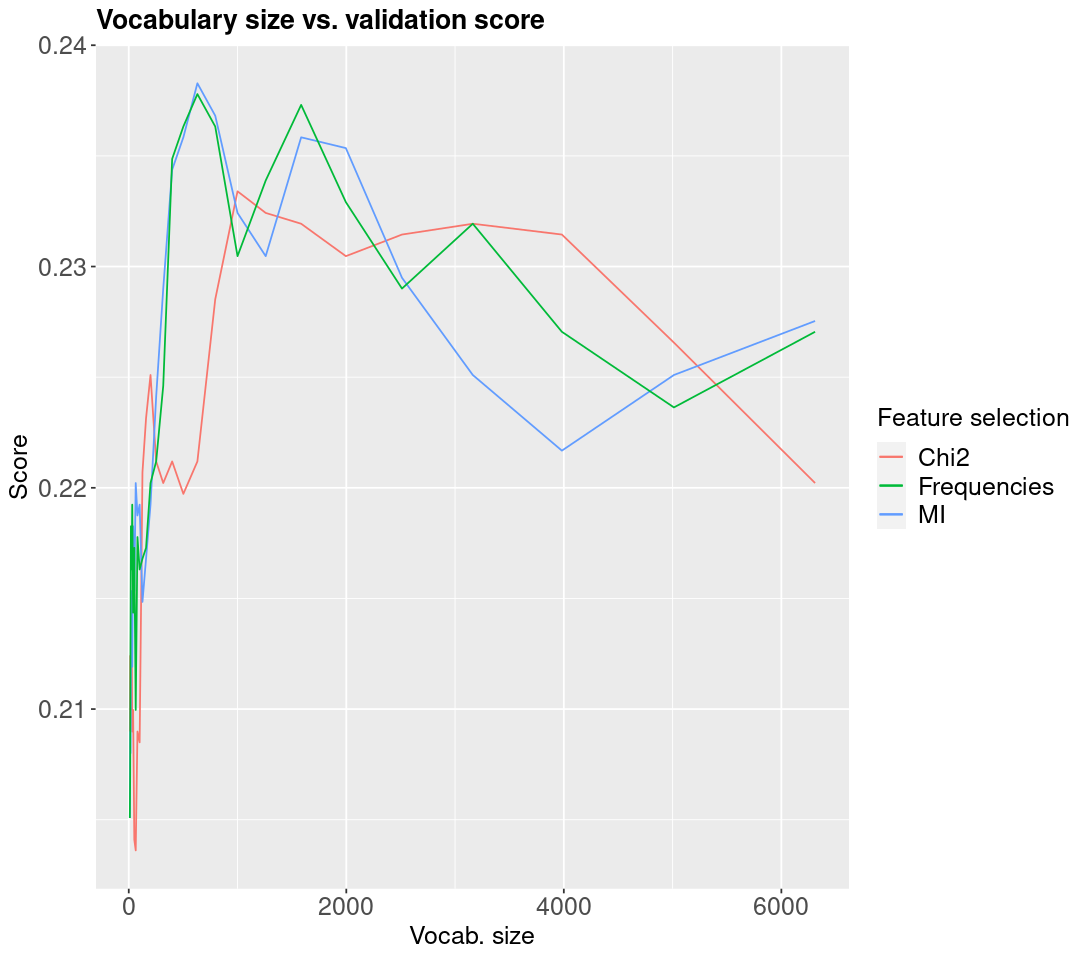

In [113]:
#Plot theme
options(repr.plot.width=9, repr.plot.height=8)

theme <- theme(legend.text = element_text(size = 15), axis.title = element_text(size = 15), axis.text = element_text(size = 15), 
               plot.title = element_text(face = "bold", size = 16), legend.title = element_text(size=15))


#Plot scores as a function of vocabulary size
grafico.scores <- ggplot() + geom_line(aes(x = scores$'Sizes', y = scores$'Chi', color = "Chi2")) + 
                                geom_line(aes(x = scores$'Sizes', y = scores$'MI', color = "MI")) + 
                                    geom_line(aes(x = scores$'Sizes', y = scores$'Frequencies', color = "Frequencies"))

#Add labels, title etc...
grafico.scores  <- grafico.scores + theme + labs(x = "Vocab. size", y = "Score") + 
                        ggtitle("Vocabulary size vs. validation score") +
                             labs(color = "Feature selection")
#Show
grafico.scores

In [123]:
#Chi2
scores[which.max(scores$"Chi"), c("Sizes", "Chi")]

,Sizes,Chi
,<dbl>,<dbl>
21,1000,0.2333984


In [122]:
#MI
scores[which.max(scores$"MI"), c("Sizes", "MI")]

,Sizes,MI
,<dbl>,<dbl>
19,631,0.2382812


In [121]:
#Frequencies
scores[which.max(scores$"Frequencies"), c("Sizes", "Frequencies")]

,Sizes,Frequencies
,<dbl>,<dbl>
19,631,0.237793


We get the best validation score using the Mutual Information and a vocabulary size of 631.

### Confusion matrix
We want to plot the confusion matrices, just to check what it is doing.

In [127]:
#Returns predicted labels on validation set
fit <- function(size){
        scores <- rep(0, length(vocab.sizes))
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Priors
    p.c <- log(NCs / n.records)

    #Posteriors
    posteriors.df <- vocab.short

    for(class in 0:(Nclasses-1)){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    
    #Make predictions
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, Nclasses) #Posterior probabilities (we want to find the maximum)
        for(class in 0:(Nclasses - 1)){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(predictions)
}

In [128]:
best.size <- scores[which.max(scores$"MI"), ]$"Sizes"  
fit.best <- fit(best.size)

In [130]:
#Compute confusion matrix on validation set
label.names <- c("Not Known", "False", "Barely True", "Half-True", "Mostly True", "True")
cm <- table(validation.df$Labels, fit.best)
row.sums <- rowSums(cm)
cm <- cm / row.sums
cm <- as.data.frame(cm)

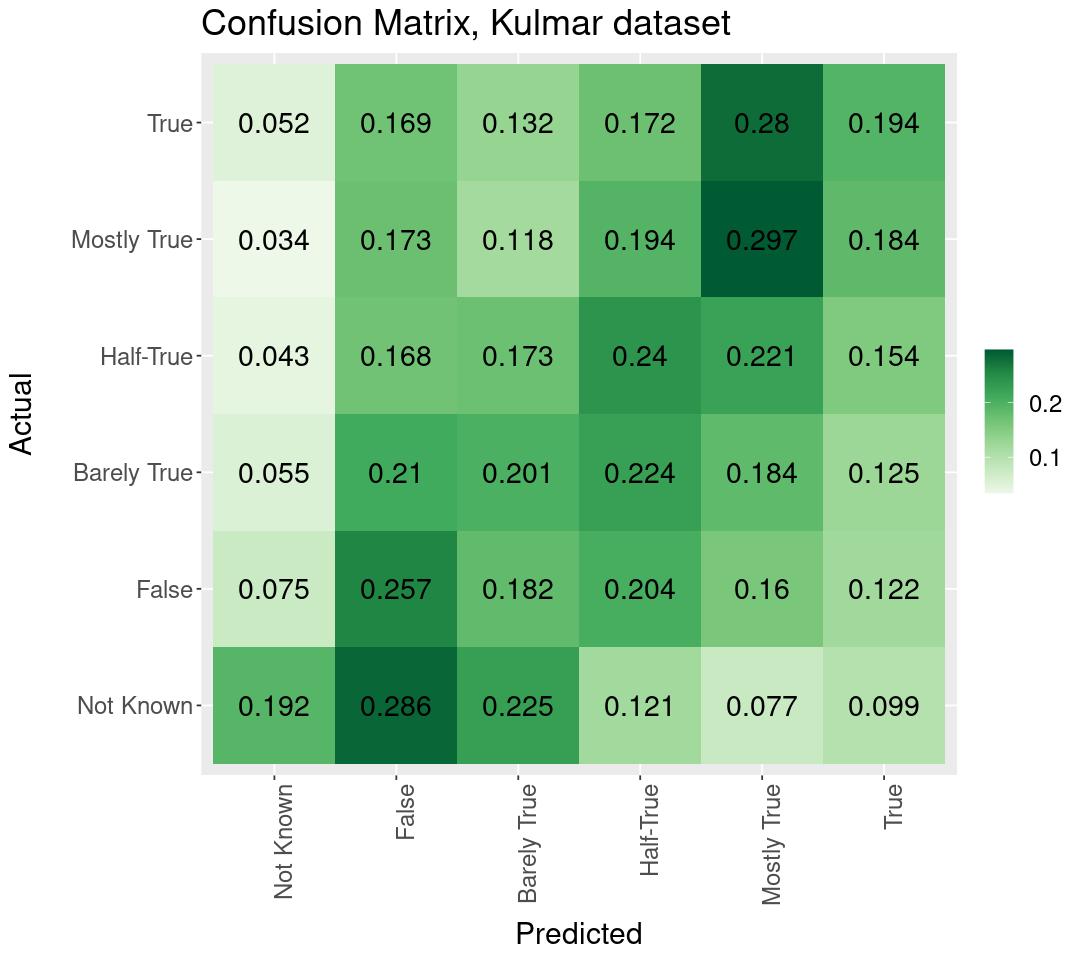

In [131]:
#Plot confusion matrix
options(repr.plot.width=9, repr.plot.height=8)


confusion.plot <- ggplot(cm, aes(x = fit.best, y = Var1, fill = Freq)) +
      geom_tile() + scale_fill_distiller(palette = "Greens", direction = +1) + 
  labs(title = "Confusion Matrix, Kulmar dataset", x = "Predicted", y = "Actual", fill = NULL) + 
geom_text(aes(label = round(Freq, digits = 3)), color = "black", size = 6)

confusion.plot +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)) +
          theme(axis.title.x = element_text(margin = margin(t = 10, r = 20, b = 0, l = 0)))+
              theme(axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0))) + 
                    scale_x_discrete(labels = label.names) + scale_y_discrete(labels = label.names)